<div align="center"> 
    <h1 align="center">Predicting the Game Outcomea in a League of Legends Match</h1>
    <h5 align="center">John Bang, SJ Yu</h5>
</div>


### Introduction

### Data Collection

In [1]:
import requests
import os
import time

summonerIds = []
API_KEY = os.getenv('API_KEY')

# Challenger League
CHAL_URL = "https://na1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5"
chal_response = requests.get(CHAL_URL, headers={'X-Riot-Token': API_KEY})

# Get the summonerID for each player in the Challenger league
entries = chal_response.json()['entries']
for entry in entries:
    summonerIds.append(entry['summonerId'])

# Grandmaster League
GM_URL = "https://na1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5"
gm_response = requests.get(GM_URL, headers={'X-Riot-Token': API_KEY})

# Get the summonerID for each player in the Grandmaster league
entries = gm_response.json()['entries']
for entry in entries:
    summonerIds.append(entry['summonerId'])

# Master League
M_URL = "https://na1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5"
m_response = requests.get(M_URL, headers={'X-Riot-Token': API_KEY})

# Get the summonerID for each player in the Master league
entries = m_response.json()['entries']
for entry in entries:
    summonerIds.append(entry['summonerId'])

In [2]:
puuids = []

# If the puuids.txt file exists, read each line of the file and store it in puuids
try: 
    with open(r'./puuids.txt', 'r') as fp:
        for line in fp:
            puuids.append(line[:-1])
        print('Opened file puuids.txt')

# If file does not exist, get data from the Riot API
except IOError:
    SUMMONER_URL = "https://na1.api.riotgames.com/lol/summoner/v4/summoners/"
    for index, id in enumerate(summonerIds, 1):
        # For every 100 requests, wait at least 2 minutes
        if index % 100 == 0:
            time.sleep(130)

        response = requests.get(SUMMONER_URL + id, headers={'X-Riot-Token': API_KEY})
        summoner = response.json()
        puuids.append(summoner['puuid'])

    # Create a new file with the puuids
    with open(r'./puuids.txt', 'w+') as fp:
        for puuid in puuids:
            fp.write(f"{puuid}\n")
        print('Created new file puuids.txt')

Opened file puuids.txt


In [3]:
# Use set for matchIds as we do not want to store duplicate matches
matchIds = set()

# If the match_ids.txt file exists, read each line of the file and store it in matchIds
try:
    with open(r'./match_ids.txt', 'r') as fp:
        for line in fp:
            matchIds.add(line[:-1])
        print('Opened file match_ids.txt')

# If file does not exist, get data from the Riot API
except IOError:
    MATCHIDS_URL = lambda x : f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{x}/ids?type=ranked&start=0&count=100"
    for index, puuid in enumerate(puuids, 1):
        # For every 100 requests, wait at least 2 minutes
        if index % 100 == 0:
            time.sleep(130)

        response = requests.get(MATCHIDS_URL(puuid), headers={'X-Riot-Token': API_KEY})
        matches = response.json()
        matchIds.update(matches)

    # Create a new file with the match_ids
    with open(r'./match_ids.txt', 'w+') as fp:
        for matchId in matchIds:
            fp.write(f"{matchId}\n")
        print('Created new file match_ids.txt')

Opened file match_ids.txt


In [4]:
import csv

teams_data = [] 

# If the team_data.csv file exists, read the csv file and store each row as a dict in teams_data
try:
    with open(r'./team_data.csv', 'r') as fp:
        csvFile = csv.DictReader(fp)

        for line in csvFile:
            teams_data.append(dict(line))
        print('Opened file team_data.txt')

# If file does not exist, get data from Riot API
except IOError:
    MATCHDATA_URL = lambda x : f"https://americas.api.riotgames.com/lol/match/v5/matches/{x}"
    
    # Column names
    fieldnames = [
        'match_id',
        'team1_champ_kills',
        'team1_baron_kills', 
        'team1_drag_kills', 
        'team1_herald_kills',
        'team1_tower_kills',
        'team1_inhib_kills',
        'team1_total_gold',
        'team1_total_dmg',
        'team1_win',
        'team2_champ_kills',
        'team2_baron_kills', 
        'team2_drag_kills', 
        'team2_herald_kills',
        'team2_tower_kills',
        'team2_inhib_kills',
        'team2_total_gold',
        'team2_total_dmg',
        'team2_win'
        ]
    for index, matchId in enumerate(matchIds, 1):
        # Get only the first 10,000 matches
        if index == 10_000:
            break

        # For every 100 requests, wait at least 2 minutes
        if index % 100 == 0:
            time.sleep(130)

        response = requests.get(MATCHDATA_URL(matchId), headers={'X-Riot-Token': API_KEY})
        match_data = response.json()

        team_data = {}
        # Only get data if the 'info' field exists
        if 'info' in match_data:
            team_data['match_id'] = matchId

            # Get information from the 'teams' field in the 'info' field
            teams = match_data['info']['teams']
            team1 = teams[0]
            team_data['team1_champ_kills'] = team1['objectives']['champion']['kills']
            team_data['team1_baron_kills'] = team1['objectives']['baron']['kills']
            team_data['team1_drag_kills'] = team1['objectives']['dragon']['kills']
            team_data['team1_herald_kills'] = team1['objectives']['riftHerald']['kills']
            team_data['team1_tower_kills'] = team1['objectives']['tower']['kills']
            team_data['team1_inhib_kills'] = team1['objectives']['inhibitor']['kills']
            team_data['team1_win'] = 1 if team1['win'] else 0

            team2 = teams[1]
            team_data['team2_champ_kills'] = team2['objectives']['champion']['kills']
            team_data['team2_baron_kills'] = team2['objectives']['baron']['kills']
            team_data['team2_drag_kills'] = team2['objectives']['dragon']['kills']
            team_data['team2_herald_kills'] = team2['objectives']['riftHerald']['kills']
            team_data['team2_tower_kills'] = team2['objectives']['tower']['kills']
            team_data['team2_inhib_kills'] = team2['objectives']['inhibitor']['kills']
            team_data['team2_win'] = 1 if team2['win'] else 0

            team1_total_gold = 0
            team1_total_dmg = 0
            team2_total_gold = 0
            team2_total_dmg = 0
            # Go through each player from the match and add all of the totalDamageDealtToChampions and goldEarned for each team
            for p in match_data['info']['participants']:
                if p['teamId'] == 100: 
                    team1_total_gold += p['goldEarned']
                    team1_total_dmg += p['totalDamageDealtToChampions']
                else:
                    team2_total_gold += p['goldEarned']
                    team2_total_dmg += p['totalDamageDealtToChampions']

            team_data['team1_total_gold'] = team1_total_gold
            team_data['team1_total_dmg'] = team1_total_dmg
            team_data['team2_total_gold'] = team2_total_gold
            team_data['team2_total_dmg'] = team2_total_dmg

            teams_data.append(team_data)

    # Create a new csv file with the team data
    with open(r'./team_data.csv', 'w+', newline='') as fp:
        writer = csv.DictWriter(fp, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(teams_data)
        print('Created new file team_data.csv')

Opened file team_data.txt


In [5]:
from collections import defaultdict

teams_data = [] 

# If the team_data_20.csv file exists, read the csv file and store each row as a dict in teams_data
try:
    with open(r'./team_data_20.csv', 'r') as fp:
        csvFile = csv.DictReader(fp)

        for line in csvFile:
            teams_data.append(dict(line))
        print('Opened file team_data_20.txt')

# If file does not exist, get data from Riot API
except IOError:
    MATCHTIMELINE_URL = lambda x : f"https://americas.api.riotgames.com/lol/match/v5/matches/{x}/timeline"
    
    # Data gathered from start to MAX_TIME (20 minutes)
    MAX_TIME = 1_210_000
    
    # Column names
    fieldnames = [
        'match_id',
        'team1_champ_kills',
        'team1_baron_kills',
        'team1_drag_kills', 
        'team1_herald_kills',
        'team1_tower_kills',
        'team1_inhib_kills',
        'team1_total_gold',
        'team1_total_dmg',
        'team2_champ_kills',
        'team2_baron_kills',
        'team2_drag_kills', 
        'team2_herald_kills',
        'team2_tower_kills',
        'team2_inhib_kills',
        'team2_total_gold',
        'team2_total_dmg',
        ]
        
    # Participant IDs
    TEAM1_IDS = ["1", "2", "3", "4", "5"]
    TEAM2_IDS = ["6", "7", "8", "9", "10"]

    for index, matchId in enumerate(matchIds[99:1000], 1):
        # Get only the first 10,000 matches
        if index == 10_000:
            break

        # For every 100 requests, wait at least 2 minutes
        if index % 100 == 0:
            time.sleep(130)

        response = requests.get(MATCHTIMELINE_URL(matchId), headers={'X-Riot-Token': API_KEY})
        match_timeline = response.json()

        team_data = defaultdict(lambda: 0) 
        # Only get data if the 'info' field exists
        if 'info' in match_timeline:
            team_data['match_id'] = matchId

            frames = match_timeline['info']['frames']
            lastFrame = {}
            # Go through each frame to get kill data
            for frame in frames:
                events = frame['events']
                timestamp = frame['timestamp']
                
                if timestamp > MAX_TIME:
                    break
                
                events = frame['events']
                for event in events:
                    if 'type' not in event:
                        continue
                    
                    match event['type']:
                        case 'CHAMPION_KILL':
                            if event['killerId'] in range(1, 6):
                                team_data['team1_champ_kills'] += 1 
                            elif event['killerId'] in range(6, 11):
                                team_data['team2_champ_kills'] += 1
                        
                        case 'ELITE_MONSTER_KILL':
                            if event['killerTeamId'] == 100:
                                team_data[f"team1_{event['monsterType']}"] += 1
                            elif event['killerTeamId'] == 200:
                                team_data[f"team2_{event['monsterType']}"] += 1
                            
                        case 'BUILDING_KILL':
                            if event['teamId'] == 200:
                                team_data[f"team1_{event['buildingType']}"] += 1
                            elif event['teamId'] == 100:
                                team_data[f"team2_{event['buildingType']}"] += 1
                             
            # Rename dictionary key names to correct csv column names
            new_key_names = [
                ('team1_drag_kills', 'team1_DRAGON'), 
                ('team1_herald_kills', 'team1_RIFTHERALD'), 
                ('team1_baron_kills', 'team1_BARON_NASHOR'), 
                ('team1_tower_kills', 'team1_TOWER_BUILDING'),
                ('team1_inhib_kills', 'team1_INHIBITOR_BUILDING'),
                ('team2_drag_kills', 'team2_DRAGON'), 
                ('team2_baron_kills', 'team2_BARON_NASHOR'), 
                ('team2_herald_kills', 'team2_RIFTHERALD'), 
                ('team2_tower_kills', 'team2_TOWER_BUILDING'),
                ('team2_inhib_kills', 'team2_INHIBITOR_BUILDING')
                ]
                    
            for new, old in new_key_names:
                team_data[new] = team_data.pop(old, 0)
                 
            lastFrame = frame

            # Get the total gold for each team
            participants = lastFrame['participantFrames']
            for id in TEAM1_IDS:
                team_data['team1_total_gold'] += participants[id]['totalGold']

            for id in TEAM2_IDS:
                team_data['team2_total_gold'] += participants[id]['totalGold']
            
            teams_data.append(team_data)
    # Create a new csv file with the team data
    with open(r'./team_data_20.csv', 'w+', newline='') as fp:
        writer = csv.DictWriter(fp, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(teams_data)
        print('Created new file team_data_20.csv')

Opened file team_data_20.txt


### Data Management

In [15]:
import pandas as pd

df_td_20 = pd.read_csv('./team_data_20.csv')
df_td = pd.read_csv('./team_data.csv')

# Delete total_dmg columns
df = df_td_20.drop('team1_total_dmg', axis=1)
df = df.drop('team2_total_dmg', axis=1)

# Delete baron_kills columns
df = df.drop('team1_baron_kills', axis=1)
df = df.drop('team2_baron_kills', axis=1)

df = df.merge(df_td[['match_id', 'team1_win', 'team2_win']], on='match_id')
df = df.dropna()

df.head()

,match_id,team1_champ_kills,team1_baron_kills,team1_drag_kills,team1_herald_kills,team1_tower_kills,team1_inhib_kills,team1_total_gold,team2_champ_kills,team2_baron_kills,team2_drag_kills,team2_herald_kills,team2_tower_kills,team2_inhib_kills,team2_total_gold,team1_win,team2_win
0,NA1_4447592729,9.0,0,2,0,3,0,36733,18.0,0,0,1,4,0,41741,0,1
1,NA1_4447592729,9.0,0,2,0,3,0,36733,18.0,0,0,1,4,0,41741,0,1
2,NA1_4452827587,16.0,0,0,0,2,0,40333,22.0,0,1,2,3,0,43092,0,1
3,NA1_4452827587,16.0,0,0,0,2,0,40333,22.0,0,1,2,3,0,43092,0,1
4,NA1_4477918900,21.0,0,3,0,3,0,43913,14.0,0,0,2,1,0,38587,1,0


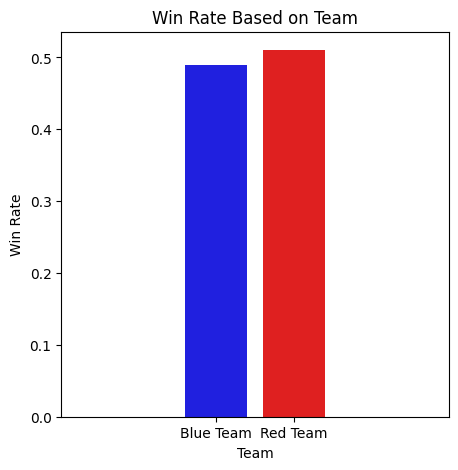

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

df_wins = df[['team1_win','team2_win']].copy()

# Calculate the winrate for the blue and red team
# Team 1 is blue team, team 2 is red team
blue_winrate = df_wins['team1_win'].sum() / len(df_wins.index)
red_winrate = df_wins['team2_win'].sum() / len(df_wins.index)

x = ['Blue Team', 'Red Team']
y = [blue_winrate, red_winrate]

clrs = ['blue' if (x == 'Blue Team') else 'red' for x in x ]

fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(x=x, y=y, data=df_wins, palette=clrs)
ax.set(xlabel='Team', ylabel='Win Rate', title='Win Rate Based on Team')
ax.set_xbound(-2, 3)

plt.show()

In [73]:
df_kills = df[['team1_champ_kills', 'team1_win', 'team2_champ_kills', 'team2_win']].copy()
# Calculate the kill ratio of the winner team (winner kills/total kills in game)
def winner_kd(row):
    total = row['team1_champ_kills'] + row['team2_champ_kills']
    num = row['team1_champ_kills'] if row['team1_win'] == 1 else row['team2_champ_kills']
    return num/total

# Calculate the kill ratio of the loser team (loser kills/total kills in game)
def loser_kd(row):
    total = row['team1_champ_kills'] + row['team2_champ_kills']
    num = row['team1_champ_kills'] if row['team2_win'] == 1 else row['team2_champ_kills']
    return num/total

# Create new columns with the kills ratios
df_kills['winner_kill_ratio'] = df_kills.apply(winner_kd, axis=1)
df_kills['loser_kill_ratio'] = df_kills.apply(loser_kd, axis=1)

# Get the total number of matches for each kill ratio
winner_kd_count = df_kills['winner_kill_ratio'].value_counts()
loser_kd_count = df_kills['loser_kill_ratio'].value_counts()
kd_count = winner_kd_count.add(loser_kd_count, fill_value=0)

# Calculate the win rate for each kill ratio
df_kills['total_wins'] = df_kills.apply(lambda row: row['team1_win'] + row['team2_win'], axis=1)
df_kills = df_kills.groupby('winner_kill_ratio')['total_wins'].sum().reset_index()
df_kills['total_games'] = df_kills.apply(lambda row: kd_count[row['winner_kill_ratio']], axis=1)
df_kills['win_rate'] = df_kills.apply(lambda row: row['total_wins'] / row['total_games'], axis=1)
# Drop any rows where we have only one game
df_kills = df_kills[df_kills['total_games'] != 1]

df_kills.head()

,winner_kill_ratio,total_wins,total_games,win_rate
0,0.181818,1.0,31.0,0.032258
1,0.214286,1.0,29.0,0.034483
2,0.227273,1.0,21.0,0.047619
3,0.233333,1.0,23.0,0.043478
4,0.240000,1.0,21.0,0.047619


[Text(0.5, 0, 'Kill Ratio'),
 Text(0, 0.5, 'Win Rate'),
 Text(0.5, 1.0, 'Kill Ratio vs Win Rate')]

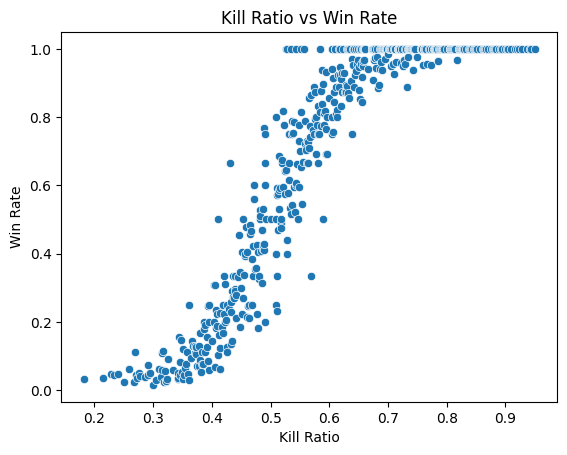

In [74]:
ax = sns.scatterplot(data=df_kills, x='winner_kill_ratio', y='win_rate')
ax.set(xlabel='Kill Ratio', ylabel='Win Rate', title='Kill Ratio vs Win Rate')

In [13]:
df['gold_diff_ratio'] = df.apply(lambda row: (row['team1_total_gold'] - row['team2_total_gold']) / (row['team1_total_gold'] + row['team2_total_gold']), axis=1)

df.head()

,match_id,team1_champ_kills,team1_baron_kills,team1_drag_kills,team1_herald_kills,team1_tower_kills,team1_inhib_kills,team1_total_gold,team2_champ_kills,team2_baron_kills,team2_drag_kills,team2_herald_kills,team2_tower_kills,team2_inhib_kills,team2_total_gold,team1_win,team2_win,gold_diff_ratio
0,NA1_4447592729,9.0,0,2,0,3,0,36733,18.0,0,0,1,4,0,41741,0,1,-0.063817
1,NA1_4447592729,9.0,0,2,0,3,0,36733,18.0,0,0,1,4,0,41741,0,1,-0.063817
2,NA1_4452827587,16.0,0,0,0,2,0,40333,22.0,0,1,2,3,0,43092,0,1,-0.033072
3,NA1_4452827587,16.0,0,0,0,2,0,40333,22.0,0,1,2,3,0,43092,0,1,-0.033072
4,NA1_4477918900,21.0,0,3,0,3,0,43913,14.0,0,0,2,1,0,38587,1,0,0.064558
